In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import s3fs
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss
from torch.utils.data import Subset


import getpass
import os
from PIL import Image

# Load FACET


In [ ]:
# KH
# s3_client = boto3.client('s3', region_name='us-west-2')

In [ ]:
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

In [ ]:
access_key = getpass.getpass("Enter your access: ")

secret_key = password = getpass.getpass("Enter your secret: ")

In [94]:
s3_client = s3fs.S3FileSystem(key=access_key, secret=secret_key)

# Use s3.open to open the CSV file and read its content into a Pandas DataFrame
with s3.open(f's3://{bucket_name}/{annotations_prefix}annotations.csv', 'rb') as file:
    gt_df = pd.read_csv(file)


In [95]:
light_weights = gt_df[['skin_tone_1', 'skin_tone_2', 'skin_tone_3', 'skin_tone_4', 'skin_tone_5']].sum(axis=1)
dark_weights = gt_df[['skin_tone_6', 'skin_tone_7', 'skin_tone_8', 'skin_tone_9', 'skin_tone_10']].sum(axis=1)

# Determine the binary flag based on the weighted average
gt_df['skin_tone_flag'] = (dark_weights > light_weights).astype(int)

In [96]:
gt_df[['skin_tone_1', 'skin_tone_2', 'skin_tone_3', 'skin_tone_4',
       'skin_tone_5', 'skin_tone_6', 'skin_tone_7', 'skin_tone_8', 
       'skin_tone_9', 'skin_tone_10','skin_tone_flag']]

,skin_tone_1,skin_tone_2,skin_tone_3,skin_tone_4,skin_tone_5,skin_tone_6,skin_tone_7,skin_tone_8,skin_tone_9,skin_tone_10,skin_tone_flag
0,2,3,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,2,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
49546,0,2,2,0,0,0,0,0,0,0,0
49547,1,3,4,3,0,0,0,0,0,0,0
49548,0,0,1,1,1,1,1,0,0,0,0
49549,0,0,2,1,1,0,0,0,0,0,0


In [97]:
gt_df.drop(columns = ['skin_tone_1', 'skin_tone_2', 'skin_tone_3', 'skin_tone_4',
       'skin_tone_5', 'skin_tone_6', 'skin_tone_7', 'skin_tone_8', 
       'skin_tone_9', 'skin_tone_10','skin_tone_flag', 'visible_torso', 'visible_face', 'visible_minimal',
       'lighting_underexposed', 'lighting_dimly_lit', 'lighting_well_lit',
       'lighting_na', 'lighting_overexposed'], inplace=True)

In [109]:
gt_df.columns

Index(['Unnamed: 0', 'person_id', 'filename', 'class1', 'class2',
       'bounding_box', 'gender_presentation_masc', 'gender_presentation_fem',
       'gender_presentation_non_binary', 'gender_presentation_na',
       'skin_tone_na', 'age_presentation_young', 'age_presentation_older',
       'age_presentation_middle', 'age_presentation_na', 'hair_color_brown',
       'hair_color_blonde', 'hair_color_grey', 'hair_color_na',
       'hair_color_black', 'hair_color_colored', 'hair_color_red',
       'hairtype_coily', 'hairtype_dreadlocks', 'hairtype_bald',
       'hairtype_straight', 'hairtype_curly', 'hairtype_wavy', 'hairtype_na',
       'has_facial_hair', 'has_tattoo', 'has_cap', 'has_mask', 'has_headscarf',
       'has_eyeware'],
      dtype='object')

In [112]:
classes = gt_df['class1'].unique()

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

idx_to_annot = {i:j for i,j in enumerate(gt_df.columns[6:])}


In [113]:
idx_to_annot

{0: 'gender_presentation_masc',
 1: 'gender_presentation_fem',
 2: 'gender_presentation_non_binary',
 3: 'gender_presentation_na',
 4: 'skin_tone_na',
 5: 'age_presentation_young',
 6: 'age_presentation_older',
 7: 'age_presentation_middle',
 8: 'age_presentation_na',
 9: 'hair_color_brown',
 10: 'hair_color_blonde',
 11: 'hair_color_grey',
 12: 'hair_color_na',
 13: 'hair_color_black',
 14: 'hair_color_colored',
 15: 'hair_color_red',
 16: 'hairtype_coily',
 17: 'hairtype_dreadlocks',
 18: 'hairtype_bald',
 19: 'hairtype_straight',
 20: 'hairtype_curly',
 21: 'hairtype_wavy',
 22: 'hairtype_na',
 23: 'has_facial_hair',
 24: 'has_tattoo',
 25: 'has_cap',
 26: 'has_mask',
 27: 'has_headscarf',
 28: 'has_eyeware'}

In [114]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [116]:
train_data, test_data = train_test_split(gt_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [150]:
batch_size = 64
class CustomDataset(Dataset):
    def __init__(self, split_data, image_dir, transform=None):
        self.data = split_data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img_name = os.path.join(self.image_dir, self.data.iloc[idx, 2])
        image = Image.open(img_name)
        annotations = self.data.iloc[idx, 6:]  # Assuming annotations are in the 6th column
        annotations = np.array([annotations], dtype = np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Create custom datasets and data loaders
image_dir = '/home/ubuntu/W210-Capstone'
start_index = 0
end_index = 50  # This index is exclusive

# Create a Subset dataset that contains the desired range of samples
subset_dataset = Subset(train_dataset, range(start_index, end_index))
train_dataset = CustomDataset(split_data=train_data, image_dir=image_dir, transform=transform)
trainloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(split_data=test_data, image_dir=image_dir, transform=transform)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(split_data=val_data, image_dir=image_dir, transform=transform)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


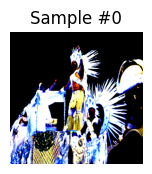

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


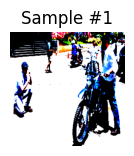

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


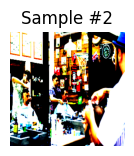

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


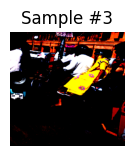

In [151]:
for i, sample in enumerate(train_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(np.transpose(sample[0], [1,2,0]))
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.show()
    if i == 3:
        break


In [152]:
def _compute_classification_recall(patch_collection, label_field):
    eval_key = "eval_" + label_field
    counts = patch_collection.count_values(eval_key)
    tp, fn = counts.get(True, 0), counts.get(False, 0)
    recall = tp/float(tp + fn) if tp > 0 else 1e-6
    return recall

In [153]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [154]:
# Hyperparameters
learning_rate = 0.01379 # 0.096779
num_epochs = 3  # 200
num_workers = 2
batch_size = 64
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 52
step_size = 30
gamma = 0.1
d_temp = 1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [155]:
# # Load IdenProf dataset
# train_path = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/train'
# test_path = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

In [156]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = torchvision.models.resnet18(weights=None).cuda()

In [157]:
# # Instantiate the models
# ###################### Testing 2 ######################
# # Create instances of your models
# teacher_model = Teacher()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = Student()

In [158]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


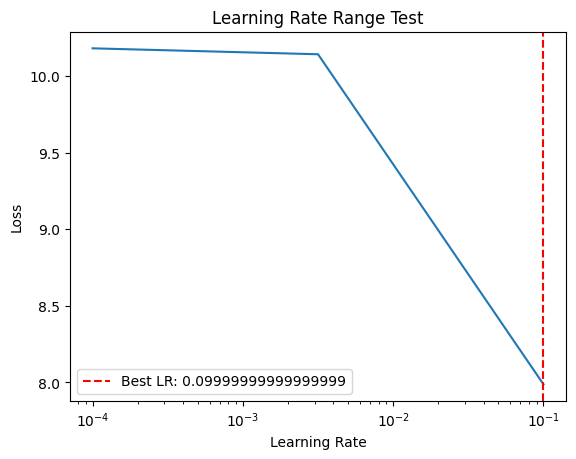

Best learning rate: 0.09999999999999999
0.09999999999999999


In [159]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels, annotation) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

############# input ############## 
batch_size = 16  #to find the optimal learning rate
best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(best_lr)

In [162]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=1, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels, annotations) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        epoch_disparity = 0.0
        running_recall = 0.0
        for i, (inputs, labels, annotations) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            
            # Calculate recall
            predicted_labels = torch.argmax(student_outputs, dim=1).cpu().numpy()
            batch_recall = recall_score(labels.cpu().numpy(), predicted_labels, average='weighted', zero_division=0)
            print(batch_recall)
            
            loss = alpha * kd_loss + (1 - alpha) * ce_loss 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            running_recall += 
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [163]:
# Assuming the device is a CUDA device if available
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation_disparity(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Finished Training Teacher


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]

0.04



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


0.04


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]

0.04



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]

0.04



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]

0.04


Finished Training Student


In [ ]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_prof.pth')
torch.save(student_model, 'student_model_ckd_prof.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_prof.pth')
torch.save(teacher_model, 'teacher_model_ckd_prof.pth')
print('teacher weights and architecture saved and exported')

In [ ]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [ ]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [ ]:
performance_metrics

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model = torchvision.models.resnet34(weights=None)

weights_path = 'teacher_model_weights_ckd_prof.pth'

teacher_model.load_state_dict(torch.load(weights_path))

student_model = torchvision.models.resnet18(weights=None)

weights_path = 'student_model_weights_ckd_prof.pth'

student_model.load_state_dict(torch.load(weights_path))

# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [108]:
for i, (image, label, annot) in enumerate(trainloader): 
    print(len(annot[0]))

29
29
29
29
29


KeyboardInterrupt: 